In [1]:
import os
import librosa 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import webrtcvad
import collections
from IPython.display import display, Audio

data_folder = '../media'
data_sets = [f for f in os.listdir(data_folder) if not f.endswith(".zip")]
source = '../media/din_raw'
snrs = os.listdir(source)
files = os.listdir(os.path.join(source, snrs[0]))

In [2]:
def estimate_snr_simple(y, frame_length=2048, hop_length=512, noise_percentile=20):
    """
    Estimate SNR of a single-channel signal using frame energy statistics.
    Assumes lowest-energy frames are noise-only.
    """
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    energies = np.mean(frames**2, axis=0)

    # Estimate noise power as the Nth percentile
    noise_power = np.percentile(energies, noise_percentile)
    signal_power = np.mean(energies)

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def get_power(y, frame_length=2048, hop_length=512):
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    energies = np.mean(frames**2, axis=0)
    return np.mean(energies)

def din_estimate_snr(y, sr):
    t = np.arange(len(y)) / sr
    mask = np.logical_and(t > .5, t < max(t) - 0.5)
    return 10 * np.log10(get_power(y[mask]) / get_power(y[~mask]))

def rms(x):
    return np.sqrt(np.mean(x ** 2))

In [3]:
bruce = os.path.join(data_folder, "din_bruce_60")
specres = os.path.join(data_folder, "din_specres_60_50")

snr_estimation = []
rmse = []
for snr in ["snr+04"]:
    for file in files:
        y_src, sr = librosa.load(os.path.join(source, snr, file), sr=16000)
        y_bruce, sr = librosa.load(os.path.join(bruce, snr, file), sr=16000)
        y_specres, sr = librosa.load(os.path.join(specres, snr, file), sr=16000)
        snr_estimation.append(
            (int(snr.replace("snr", "")), file, 
             din_estimate_snr(y_src, sr), 
             din_estimate_snr(y_bruce, sr),
             din_estimate_snr(y_specres, sr),
            ))
        
        rmse.append(
             (int(snr.replace("snr", "")), file, 
             rms(y_src), 
             rms(y_bruce),
             rms(y_specres),
            )
        )

snr_estimation = pd.DataFrame(snr_estimation, columns=["snr", "file", "raw", "bruce", "specres"])
rmse = pd.DataFrame(rmse, columns=["snr", "file", "raw", "bruce", "specres"])

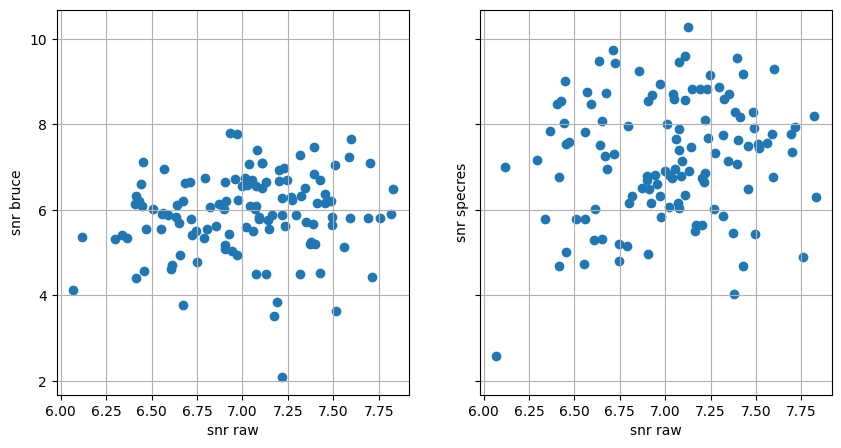

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax1.scatter(snr_estimation['raw'], snr_estimation['bruce'])
ax1.set_xlabel("snr raw")
ax1.set_ylabel("snr bruce")
ax1.grid()

ax2.scatter(snr_estimation['raw'], snr_estimation['specres'])
ax2.set_xlabel("snr raw")
ax2.set_ylabel("snr specres")
ax2.grid()

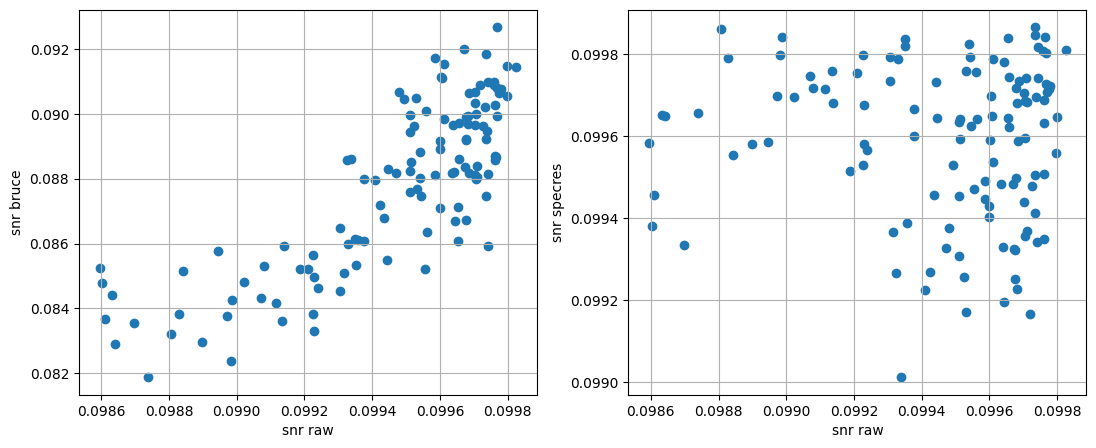

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.scatter(rmse['raw'], rmse['bruce'])
ax1.set_xlabel("snr raw")
ax1.set_ylabel("snr bruce")
ax1.grid()

ax2.scatter(rmse['raw'], rmse['specres'])
ax2.set_xlabel("snr raw")
ax2.set_ylabel("snr specres")
ax2.grid()

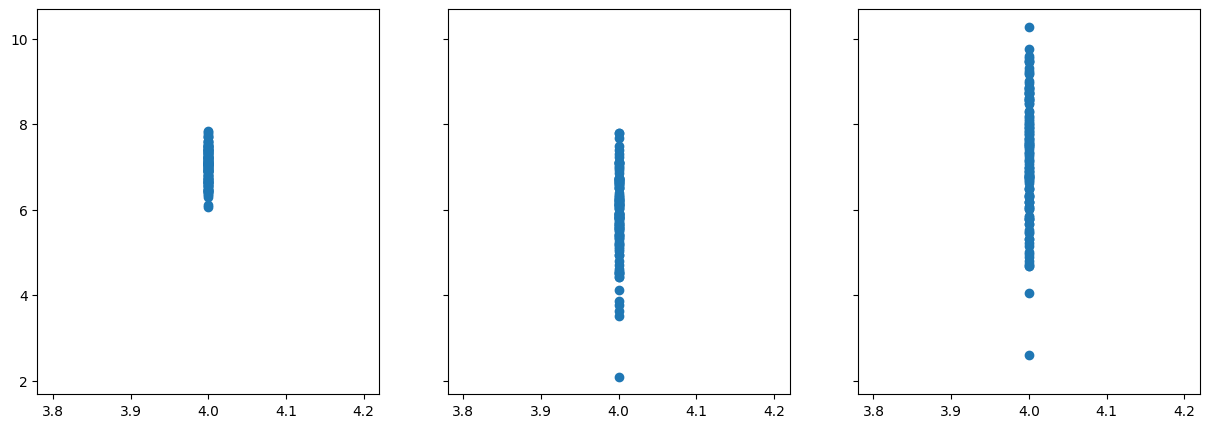

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax1.scatter(snr_estimation['snr'], snr_estimation['raw'])
ax2.scatter(snr_estimation['snr'], snr_estimation['bruce'])
ax3.scatter(snr_estimation['snr'], snr_estimation['specres'])

In [7]:
from mir_eval.separation import bss_eval_sources

sdr, sir, sar, perm = bss_eval_sources(y_src, y_bruce)
sdr, sir, sar, perm

/tmp/ipykernel_1339380/2728181420.py:3: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, perm = bss_eval_sources(y_src, y_bruce)


(array([-16.85184594]), array([inf]), array([-16.85184594]), array([0]))

In [ ]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from pesq import pesq
from pystoi import stoi

def compute_mcd(y1, y2):
    """
    Compute MCD between two MFCC matrices using DTW alignment.
    """
    # Exclude 0th coefficient (energy)
    mfcc1 = librosa.feature.mfcc(y=y1, sr=sr, n_mfcc=13, hop_length=512)
    mfcc2 = librosa.feature.mfcc(y=y2, sr=sr, n_mfcc=13, hop_length=512)
    
    mfcc1 = mfcc1[1:].T  # shape: (frames, coefficients)
    mfcc2 = mfcc2[1:].T

    # Use DTW to align sequences
    distance, path = fastdtw(mfcc1, mfcc2, dist=euclidean)

    # Compute MCD over aligned path
    mcd_total = 0.0
    for i, j in path:
        diff = mfcc1[i] - mfcc2[j]
        mcd_total += np.sqrt(np.sum(diff ** 2))

    mcd_const = 10.0 / np.log(10) * np.sqrt(2)
    return mcd_const * mcd_total / len(path)

def si_sdr(reference, estimation, eps=1e-8):
    # Ensure same length
    min_len = min(len(reference), len(estimation))
    reference = reference[:min_len]
    estimation = estimation[:min_len]

    # Remove mean
    reference -= np.mean(reference)
    estimation -= np.mean(estimation)

    # Projection of estimation onto reference
    scaling_factor = np.dot(estimation, reference) / (np.linalg.norm(reference) ** 2 + eps)
    projection = scaling_factor * reference

    noise = estimation - projection

    si_sdr_value = 10 * np.log10(np.sum(projection ** 2) / (np.sum(noise ** 2) + eps))
    return si_sdr_value

def get_pesq(y1, y2, sr):
    try:
        return pesq(sr, y1, y2, 'wb')  
    except: 
        return float("inf")
    

from collections import namedtuple

Measures = namedtuple("Measures", [
    "dtw_distance", 
    "mse", 
    "stoi",  # Range: 0.0 to 1.0, higher better
    "mcd",   # Range dB, lower is better
    "pesq",  # range 0 5, higher better
    "si_sdr" # range -inf, 20 (dB), higher is better
])

def compute_measures(y1, y2, sr):
    dtw_distance, path = fastdtw(y1, y2)
    path = np.array(path)
    y1_path = path[:, 0]
    y2_path = path[:, 1]
  
    return Measures(
        dtw_distance, 
        np.mean((y1[y1_path] - y2[y2_path])**2), 
        stoi(y1[y1_path], y2[y2_path], sr, extended=False), 
        compute_mcd(y1[y1_path], y2[y2_path]),
        get_pesq(y1[y1_path], y2[y2_path], sr),
        si_sdr(y1[y1_path], y2[y2_path])
    )

(Measures(dtw_distance=np.float64(2965.282461552728), mse=np.float32(0.004780121), stoi=np.float64(0.3115174289637608), mcd=np.float64(346.93841499864226), pesq=1.0901386737823486, si_sdr=np.float32(-1.5123327)),
 Measures(dtw_distance=np.float64(3492.3681096895707), mse=np.float32(0.007107224), stoi=np.float64(0.599315909196877), mcd=np.float64(351.36659844870616), pesq=1.3484538793563843, si_sdr=np.float32(-2.9629169)))

In [ ]:
def comparison(snr, file):
    measures = []
    y_src, sr = librosa.load(os.path.join(source, snr, file), sr=16000)
    y_bruce, sr = librosa.load(os.path.join(bruce, snr, file), sr=16000)
    y_specres, sr = librosa.load(os.path.join(specres, snr, file), sr=16000)
    measures.append((
        list((int(snr.replace("snr", "")), file, "bruce")) + 
        list(compute_measures(y_src, y_bruce, sr))
    ))
    measures.append((
        list((int(snr.replace("snr", "")), file, "specres")) + 
        list(compute_measures(y_src, y_specres, sr))
    ))
    return measures


measures = []
from multiprocessing import Pool

for snr in snrs:
    print(snr)
    def inner(f):
        return comparison(snr, f)
    
    with Pool(32) as p:
        res = p.map(inner, files)
        for x in res:
            measures.extend(x)
    
measures = pd.DataFrame(measures, columns=['snr', 'file', 'source'] + list(Measures._fields))

snr-10
snr+08
snr+06
snr-02
snr-06
snr-12
snr+02
snr+10


,snr,file,source,dtw_distance,mse,stoi,mcd,pesq,si_sdr
0,4,247.wav,bruce,2912.135738,0.005752,0.266896,324.558850,1.022431,-3.296218
1,4,247.wav,specres,3929.612187,0.009109,0.462290,409.597956,1.281679,-6.862660
2,4,846.wav,bruce,2744.316256,0.006155,0.370235,296.708990,1.043721,-3.699499
3,4,846.wav,specres,3399.403457,0.007063,0.548904,367.842238,1.152174,-2.966666
4,4,821.wav,bruce,2729.806861,0.006210,0.276069,307.241112,1.025133,-4.008090
...,...,...,...,...,...,...,...,...,...
235,4,683.wav,specres,3214.831508,0.007092,0.575559,362.575907,1.176292,-3.404870
236,4,109.wav,bruce,2552.785504,0.004442,0.309867,330.304306,1.030008,-0.137253
237,4,109.wav,specres,3908.984258,0.007713,0.411979,415.186635,1.066405,-4.018098
238,4,915.wav,bruce,3011.116692,0.005039,0.310528,349.475422,1.044647,-2.033643
